pip install -U finance-datareader

from google.colab import drive
drive.mount('/content/drive/')

cd 'drive/MyDrive/BOAZ/분석/미니프로젝트'

In [1]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr

from sklearn.linear_model import LinearRegression
from tqdm import tqdm


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
%matplotlib inline

In [2]:
stock_list = pd.read_csv('Stock_List.csv')

stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list 

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [3]:
#상장폐지된 녹십자셀제거
indexdelete=stock_list[stock_list['종목코드']=='031390'].index
stock_list=stock_list.drop(indexdelete)
stock_list=stock_list.reset_index(drop=True)
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
364,맘스터치,220630,KOSDAQ
365,다날,064260,KOSDAQ
366,제이시스메디칼,287410,KOSDAQ
367,크리스에프앤씨,110790,KOSDAQ


In [4]:
start_date = '20200520' #시작 날짜 지정해주기
end_date = '20220218' #끝나는 날짜 지정해주기

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date']) 

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}',)

WEEKDAY of "start_date" : 2
NUM of WEEKS to "end_date" : 07
HOW MANY "Business_days" : (458, 1)


In [5]:
#for code in tqdm(stock_list['종목코드'].values): #370개의 종목코드 반복문으로 돌려줌
#    data = fdr.DataReader(code, start = start_date, end = end_date)[['Close']].reset_index() 
#    data = pd.merge(Business_days, data, how = 'outer')
#    data['weekday'] = data.Date.apply(lambda x : x.weekday())
#    data['weeknum'] = data.Date.apply(lambda x : x.strftime('%V'))
#    data.Close = data.Close.ffill()
#    data = pd.pivot_table(data = data, values = 'Close', columns = 'weekday', index = 'weeknum')

In [6]:
#EDA용 삼성전자 데이터셋
start_date = '20200528' #시작 날짜 지정해주기
end_date = '20220218' #끝나는 날짜 지정해주기
samsungstock = fdr.DataReader('005930', start = start_date, end = end_date)[['Close','Open','High','Low','Volume','Change']] 
samsungstock['High-Low']=samsungstock['High']-samsungstock['Low'] #고가-저가 변수 추가
samsungstock['Close-Open']=samsungstock['Close']-samsungstock['Open'] #종가-시가 변수 추가

exchange=fdr.DataReader('USD/KRW', start = start_date, end = end_date)[['Close']] 
exchange.columns=['exchange']
kospi=fdr.DataReader('KS11', start = start_date, end = end_date)[['Close']] 
kospi.columns=['kospi']
kosdaq=fdr.DataReader('KQ11', start = start_date, end = end_date)[['Close']] 
kosdaq.columns=['kosdaq']
dow=fdr.DataReader('DJI', start = start_date, end = end_date)[['Close']] 
dow.columns=['dow']
nasdaq=fdr.DataReader('IXIC',start = start_date, end = end_date)[['Close']] 
nasdaq.columns=['nasdaq']
sp500=fdr.DataReader('US500', start = start_date, end = end_date)[['Close']] 
sp500.columns=['sp500']

newvariable = pd.concat([samsungstock,exchange,kospi,kosdaq,dow,nasdaq,sp500],axis=1, join='outer')
newvariable=newvariable.reset_index()


미국 지수 하루 씩 미뤄주고 null값 채워서 데이터셋 다시 만들기 ▼

In [7]:
dow_nan = newvariable[newvariable['dow'].isnull()].index
nasdaq_nan = newvariable[newvariable['nasdaq'].isnull()].index
sp500_nan = newvariable[newvariable['sp500'].isnull()].index

In [8]:
for i in dow_nan:
    for j in range(6,12):
        n = newvariable.iloc[i-1,-j]
        newvariable.iloc[i,-j] = n

In [9]:
for i in nasdaq_nan:
    for j in range(6,12):
        n = newvariable.iloc[i-1,-j]
        newvariable.iloc[i,-j] = n

In [10]:
for i in sp500_nan:
    for j in range(6,12):
        n = newvariable.iloc[i-1,-j]
        newvariable.iloc[i,-j] = n

In [11]:
newvariable[['dow','nasdaq','sp500']] = newvariable[['dow','nasdaq','sp500']].shift(1)
newvariable.isnull().sum()

Date           0
Close         23
Open          23
High          23
Low           23
Volume        23
Change        23
High-Low      23
Close-Open    23
exchange       0
kospi         23
kosdaq        23
dow           15
nasdaq        15
sp500         15
dtype: int64

In [12]:
Close_nan = newvariable[newvariable['Close'].isnull()].index
Open_nan = newvariable[newvariable['Open'].isnull()].index
High_nan = newvariable[newvariable['High'].isnull()].index
Low_nan = newvariable[newvariable['Low'].isnull()].index
Volume_nan = newvariable[newvariable['Volume'].isnull()].index
Change_nan = newvariable[newvariable['Change'].isnull()].index
High_Low_nan = newvariable[newvariable['High-Low'].isnull()].index
kospi_nan = newvariable[newvariable['kospi'].isnull()].index
kosdaq_nan = newvariable[newvariable['kosdaq'].isnull()].index

In [13]:
nan_list = set(Close_nan.to_list() + Open_nan.to_list() + High_nan.to_list() +
               Low_nan.to_list() + Volume_nan.to_list() + Change_nan.to_list() + High_Low_nan.to_list() + 
               kospi_nan.to_list() + kosdaq_nan.to_list())

In [14]:
newvariable.drop(nan_list, inplace=True)

In [15]:
newvariable.drop(0, axis=0, inplace=True)

In [16]:
newvariable.isnull().sum()

Date           0
Close          0
Open           0
High           0
Low            0
Volume         0
Change         0
High-Low       0
Close-Open     0
exchange       0
kospi          0
kosdaq         0
dow           14
nasdaq        14
sp500         14
dtype: int64

In [17]:
newvariable_a = newvariable.interpolate("ffill") #ffill=이전값으로 채워주기(?)
newvariable_a.isnull().sum()

Date          0
Close         0
Open          0
High          0
Low           0
Volume        0
Change        0
High-Low      0
Close-Open    0
exchange      0
kospi         0
kosdaq        0
dow           0
nasdaq        0
sp500         0
dtype: int64

In [18]:
newvariable_a=newvariable_a.reset_index(drop=True) # index (0~354)순서대로 재설정
newvariable_a

,Date,Close,Open,High,Low,Volume,Change,High-Low,Close-Open,exchange,kospi,kosdaq,dow,nasdaq,sp500
0,2020-05-29,50700.0,50000.0,50700.0,49700.0,27596961.0,0.005952,1000.0,700.0,1231.49,2029.60,713.68,25400.64,9368.99,3029.73
1,2020-06-01,51200.0,50800.0,51200.0,50600.0,16949183.0,0.009862,600.0,400.0,1222.92,2065.08,735.72,25383.11,9489.87,3044.31
2,2020-06-02,51400.0,51000.0,51500.0,50800.0,14247933.0,0.003906,700.0,400.0,1219.62,2087.19,743.58,25475.02,9552.05,3055.73
3,2020-06-03,54500.0,51800.0,55000.0,51700.0,49257814.0,0.060311,3300.0,2700.0,1215.79,2147.00,737.66,25742.65,9608.38,3080.82
4,2020-06-04,54600.0,55800.0,57000.0,54600.0,40220334.0,0.001835,2400.0,-1200.0,1216.39,2151.18,742.37,26269.89,9682.91,3122.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,2022-02-14,73700.0,74400.0,74500.0,73100.0,13993255.0,-0.016021,1400.0,-700.0,1197.32,2704.48,852.79,34737.47,13791.15,4418.64
423,2022-02-15,73700.0,74100.0,74200.0,73100.0,9320365.0,0.000000,1100.0,-400.0,1196.76,2676.54,839.92,34565.78,13790.92,4401.67
424,2022-02-16,74800.0,74600.0,74900.0,74200.0,10767386.0,0.014925,700.0,200.0,1196.53,2729.68,878.15,34988.31,14139.76,4471.07
425,2022-02-17,75000.0,75000.0,75600.0,74500.0,13605382.0,0.002674,1100.0,0.0,1198.63,2744.09,874.22,34935.59,14124.09,4475.01


In [19]:
# maN : N일전부터 현재까지의 종가 이동평균
newvariable_b=fdr.DataReader('005930', start = '20200518', end = end_date)[['Close']] #이동평균 만들고 na채워주려고 더 이전의 데이터 불러옴
ma10 = newvariable_b['Close'].rolling(window=10).mean()
ma10=pd.DataFrame(ma10.dropna()).reset_index()
ma10.columns=['Date','ma10']
df=pd.merge(newvariable_a,ma10, on="Date") #데이터에 이동평균 추가해주기
df=df.set_index('Date')


In [20]:
#볼린저밴드
k=2
#중심선 (MBB) : n일 이동평균선
mbb = newvariable_b.rolling(10).mean()
MA10_std = newvariable_b.rolling(10).std()
#상한선 (UBB) : 중심선 + (표준편차 × K)
#하한선 (LBB) : 중심선 - (표준편차 × K)
ubb=mbb+k*MA10_std
lbb=mbb-k*MA10_std
bb = ubb - lbb
bb.columns=['bb']
df=pd.merge(df,bb,on="Date")#볼린저밴드 데이터에 추가

In [21]:
df

,Close,Open,High,Low,Volume,Change,High-Low,Close-Open,exchange,kospi,kosdaq,dow,nasdaq,sp500,ma10,bb
Date,,,,,,,,,,,,,,,,
2020-05-29,50700.0,50000.0,50700.0,49700.0,27596961.0,0.005952,1000.0,700.0,1231.49,2029.60,713.68,25400.64,9368.99,3029.73,49690.0,2884.132837
2020-06-01,51200.0,50800.0,51200.0,50600.0,16949183.0,0.009862,600.0,400.0,1222.92,2065.08,735.72,25383.11,9489.87,3044.31,49930.0,3152.706069
2020-06-02,51400.0,51000.0,51500.0,50800.0,14247933.0,0.003906,700.0,400.0,1219.62,2087.19,743.58,25475.02,9552.05,3055.73,50040.0,3650.022831
2020-06-03,54500.0,51800.0,55000.0,51700.0,49257814.0,0.060311,3300.0,2700.0,1215.79,2147.00,737.66,25742.65,9608.38,3080.82,50490.0,6714.362715
2020-06-04,54600.0,55800.0,57000.0,54600.0,40220334.0,0.001835,2400.0,-1200.0,1216.39,2151.18,742.37,26269.89,9682.91,3122.87,50955.0,8411.341550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-14,73700.0,74400.0,74500.0,73100.0,13993255.0,-0.016021,1400.0,-700.0,1197.32,2704.48,852.79,34737.47,13791.15,4418.64,73710.0,4624.379838
2022-02-15,73700.0,74100.0,74200.0,73100.0,9320365.0,0.000000,1100.0,-400.0,1196.76,2676.54,839.92,34565.78,13790.92,4401.67,73950.0,3167.894499
2022-02-16,74800.0,74600.0,74900.0,74200.0,10767386.0,0.014925,700.0,200.0,1196.53,2729.68,878.15,34988.31,14139.76,4471.07,74100.0,3188.869531


In [22]:
df.isnull().sum()

Close         0
Open          0
High          0
Low           0
Volume        0
Change        0
High-Low      0
Close-Open    0
exchange      0
kospi         0
kosdaq        0
dow           0
nasdaq        0
sp500         0
ma10          0
bb            0
dtype: int64

------------- 모든 변수 넣은 df 데이터셋 완성-----

In [23]:
def label(x):
  if x>=0:
    Close=1
  else:
    Close=0
  return Close

In [24]:
df['Close'] = (df.Close - df.Close.shift(1))/df.Close.shift(1)*100
df=df.dropna()
df["Close"] = df["Close"].apply(lambda x:label(x))
df["Close"] = df["Close"].astype('category')

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## 변수 선택 및 전처리 위한 EDA

In [25]:
#다중공선성확인 =>데이터 셋에 null 값 없어야지만 돌아감
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_vif=df.drop(['Close'],axis=1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif["features"] = df_vif.columns 
vif
#다중공선성 확인 결과 Open High Low sp500 제거!

,VIF Factor,features
0,89470.239242,Open
1,142126.017582,High
2,81966.875236,Low
3,19.372171,Volume
4,3.298499,Change
5,46.911308,High-Low
6,7.489996,Close-Open
7,433.300846,exchange
8,2995.973345,kospi
9,2194.263231,kosdaq


In [26]:
df.dtypes

Close         category
Open           float64
High           float64
Low            float64
Volume         float64
Change         float64
High-Low       float64
Close-Open     float64
exchange       float64
kospi          float64
kosdaq         float64
dow            float64
nasdaq         float64
sp500          float64
ma10           float64
bb             float64
dtype: object

In [27]:
df.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'High-Low',
       'Close-Open', 'exchange', 'kospi', 'kosdaq', 'dow', 'nasdaq', 'sp500',
       'ma10', 'bb'],
      dtype='object')

In [28]:
df.describe()

,Open,High,Low,Volume,Change,High-Low,Close-Open,exchange,kospi,kosdaq,dow,nasdaq,sp500,ma10,bb
count,426.000000,426.000000,426.000000,4.260000e+02,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,72294.131455,72939.906103,71615.258216,1.928498e+07,0.000766,1323.474178,-83.802817,1154.097300,2835.994836,934.520188,32005.491854,13268.394085,3985.762887,71963.028169,5104.529851
std,10563.187501,10630.150416,10520.549172,8.729558e+06,0.015202,784.654676,939.133818,36.367053,371.529070,89.693081,3413.682407,1756.234562,511.641878,10707.503399,3120.338902
min,50800.000000,51200.000000,49900.000000,8.395448e+06,-0.045889,400.000000,-2500.000000,1083.530000,2030.820000,693.150000,25015.550000,9489.870000,3002.100000,49930.000000,942.809042
25%,60700.000000,61025.000000,60175.000000,1.350923e+07,-0.008395,800.000000,-600.000000,1120.070000,2433.242500,866.802500,28647.712500,11770.412500,3510.820000,59945.000000,2728.362111
50%,75350.000000,75900.000000,74500.000000,1.705522e+07,0.000000,1100.000000,-100.000000,1156.295000,2986.215000,963.155000,33515.380000,13629.455000,4088.560000,75340.000000,4248.812346
75%,81000.000000,81400.000000,80450.000000,2.224766e+07,0.008272,1600.000000,375.000000,1187.147500,3140.460000,1004.680000,34898.035000,14683.717500,4436.692500,80730.000000,6573.297864
max,90300.000000,96800.000000,89500.000000,9.030618e+07,0.071170,7300.000000,5500.000000,1222.920000,3305.210000,1060.000000,36799.650000,16057.440000,4796.560000,88510.000000,18408.886743


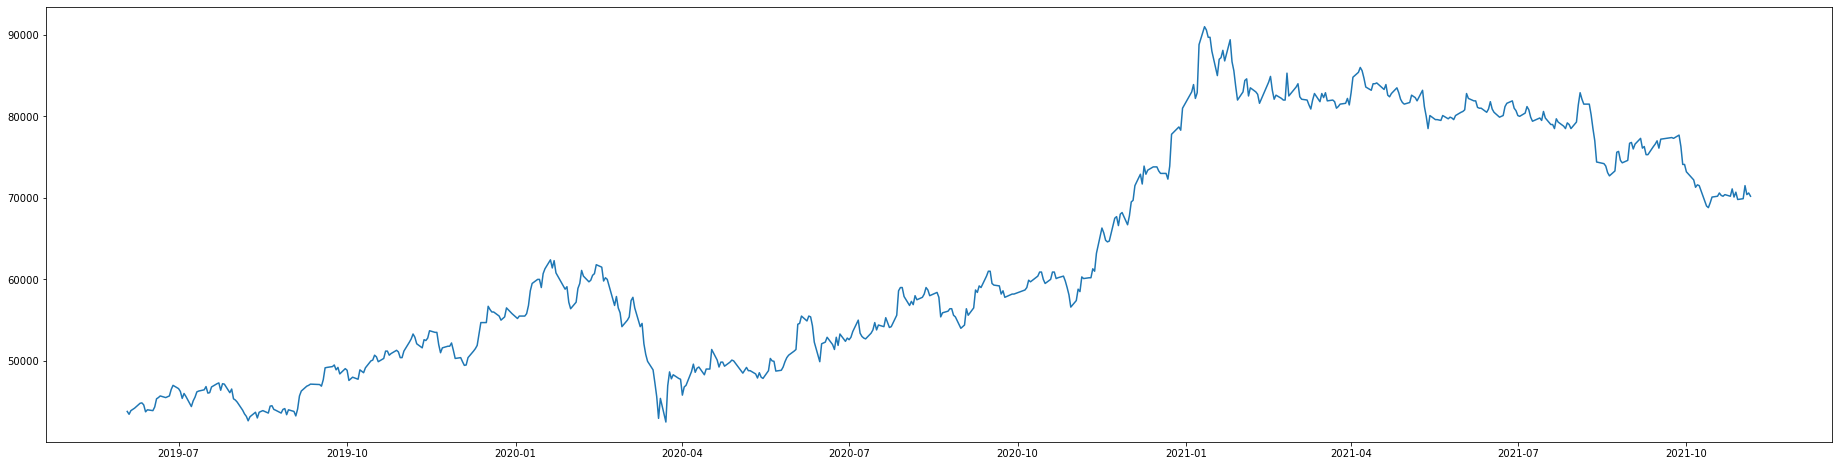

In [29]:
#주가변동확인
samsungstock2 = fdr.DataReader('005930', start = '20190601', end = '20211105')[['Close']]
plt.figure(figsize=(32,8))
plt.plot(samsungstock2.Close)
plt.show()

<AxesSubplot:>

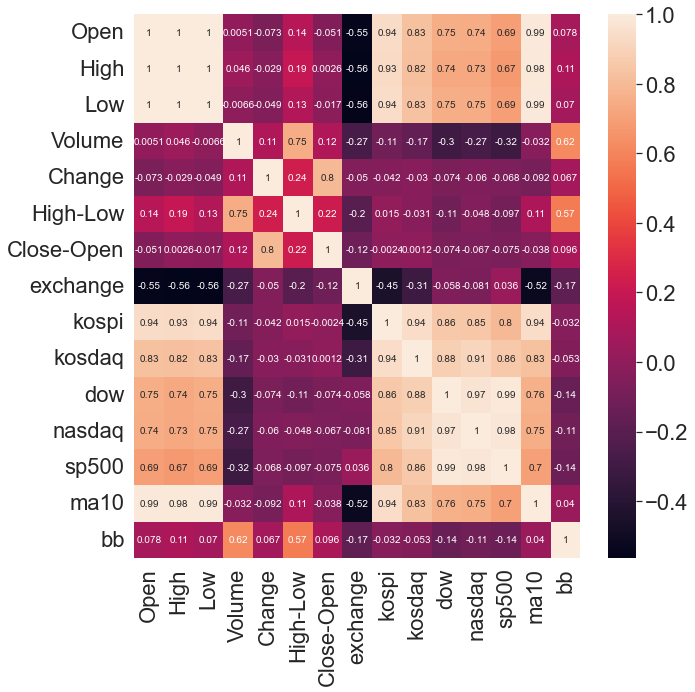

In [30]:
#삼성전자 상관분석
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(df.corr(),
               annot= True,
               annot_kws={"size": 10})
#open high low snp500 제거 해야할듯

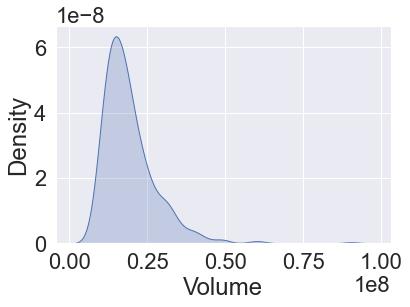

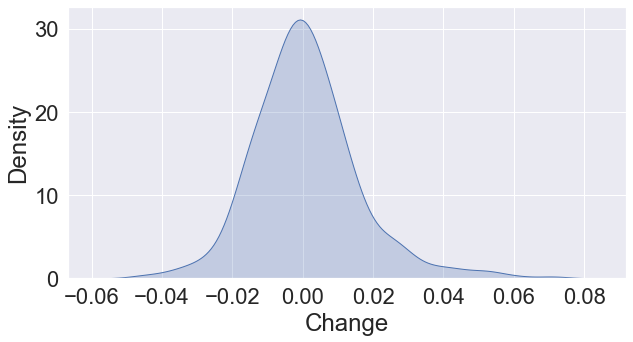

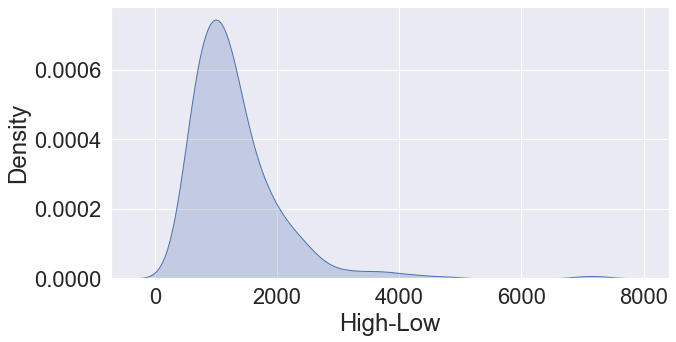

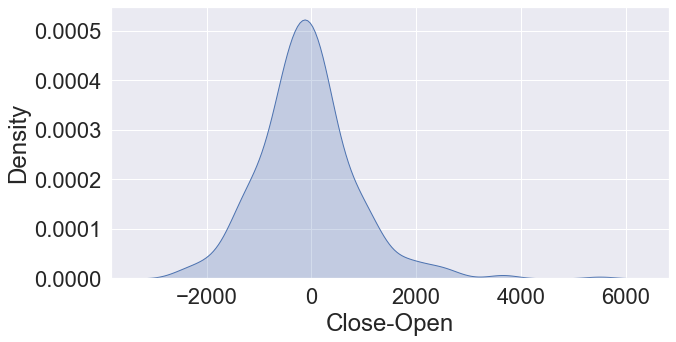

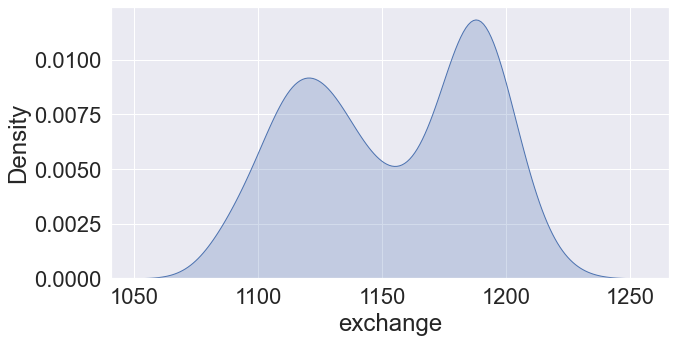

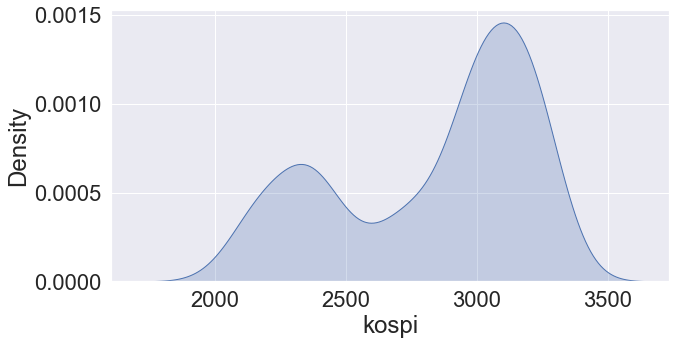

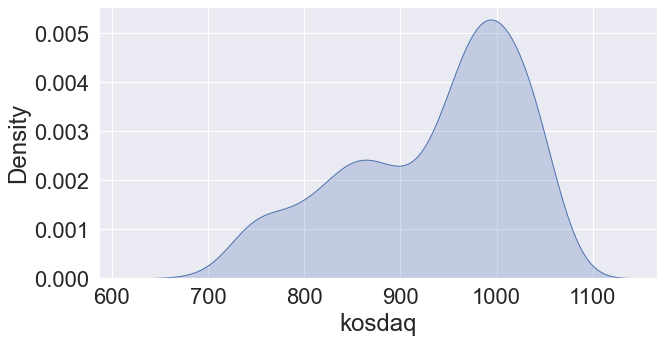

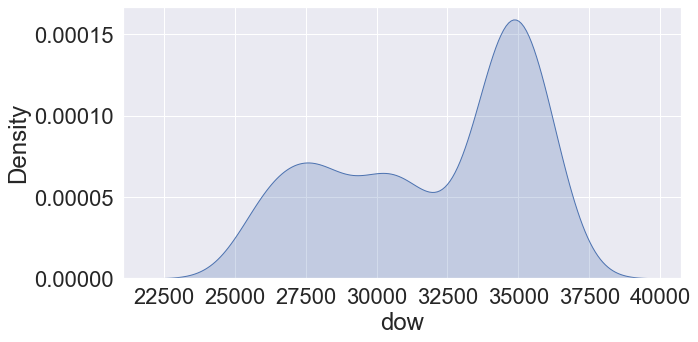

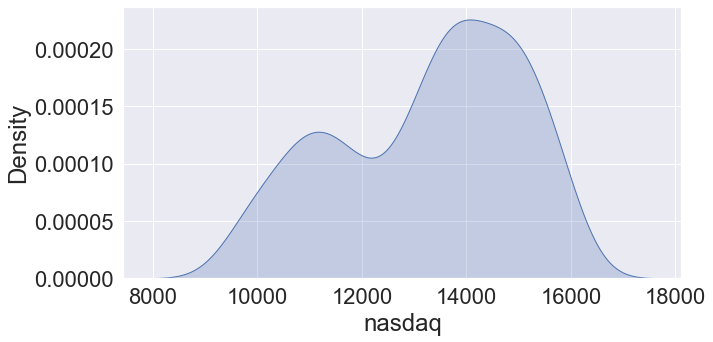

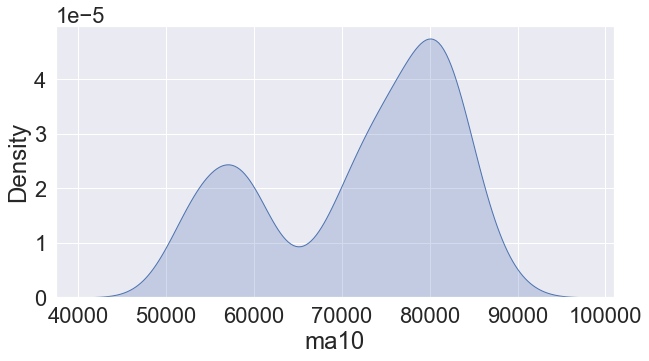

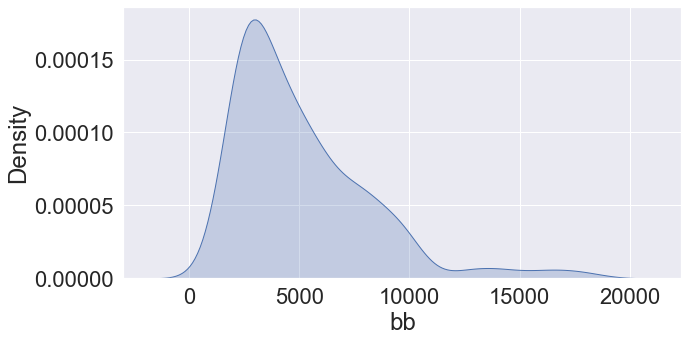

<Figure size 720x360 with 0 Axes>

In [31]:
#밀도만 확인
for col in df.columns:
    if col in ['Volume','Change','High-Low','Close-Open','exchange','kospi',
              'kosdaq','dow','nasdaq','ma10','bb']:
        sns.kdeplot(data=df, x=df[col], shade = True)
        plt.figure(figsize=(10,5))

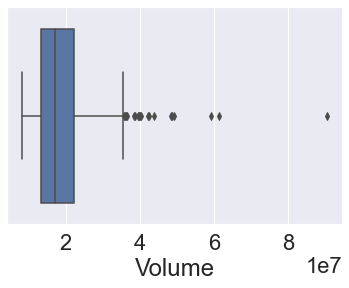

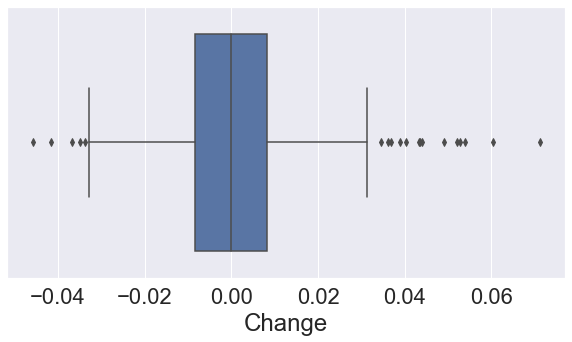

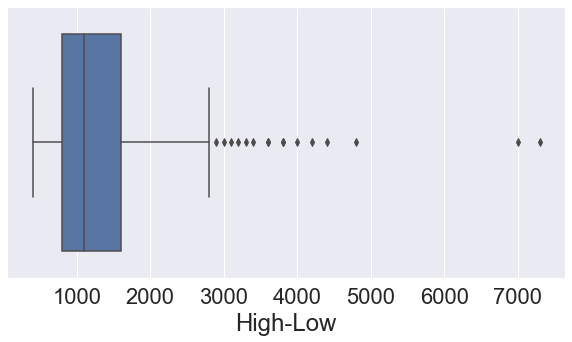

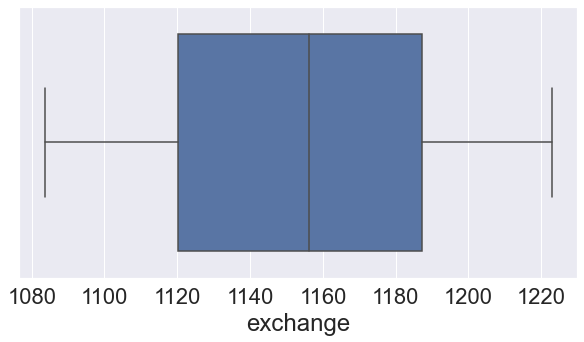

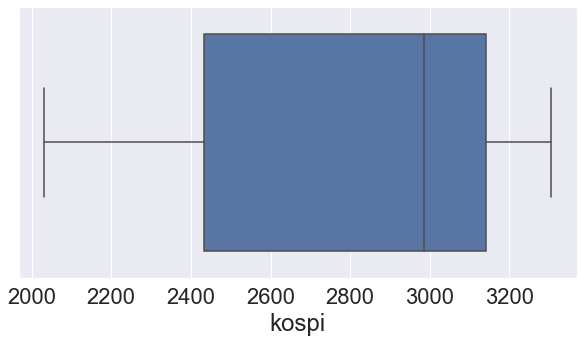

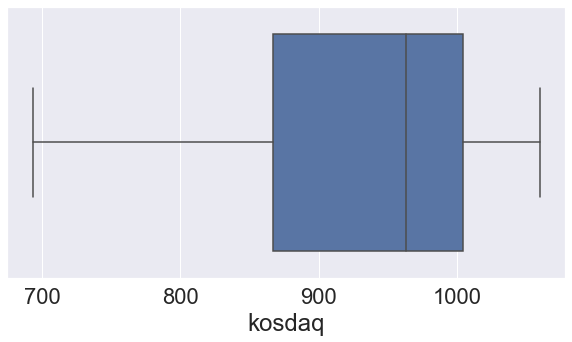

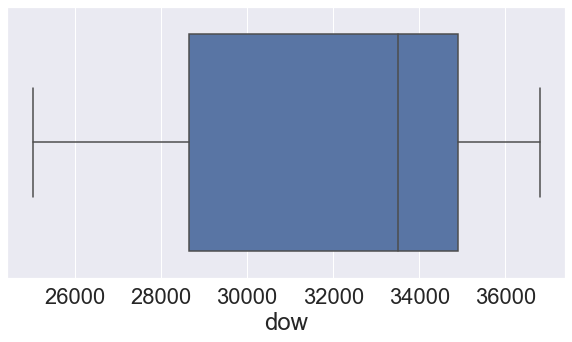

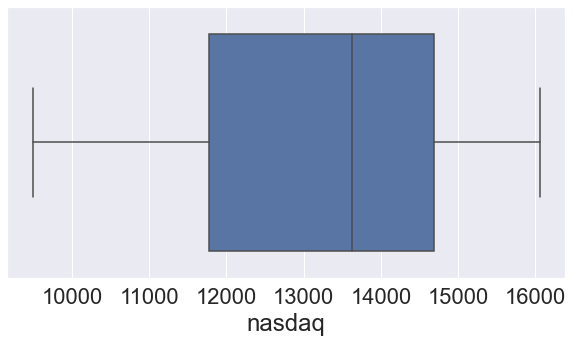

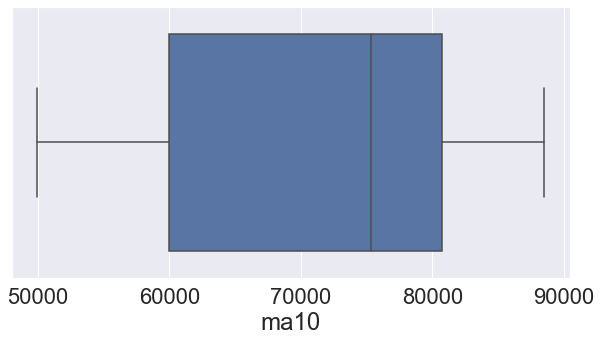

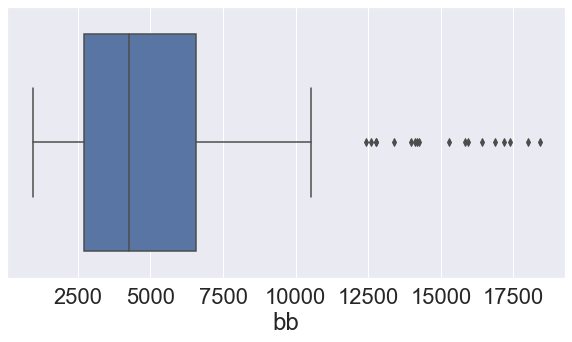

<Figure size 720x360 with 0 Axes>

In [32]:
#사분위수로 이상치 확인
for col in df.columns:
    if col in ['Volume','Change','High-Low','exchange','kospi',
              'kosdaq','dow','nasdaq','ma10','bb']:
        sns.boxplot(data=df, x=df[col])
        plt.figure(figsize=(10,5))

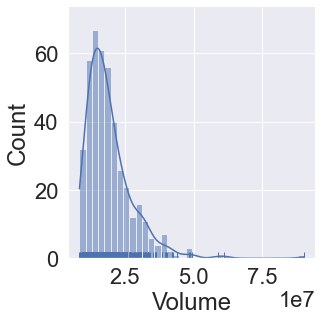

<Figure size 1080x720 with 0 Axes>

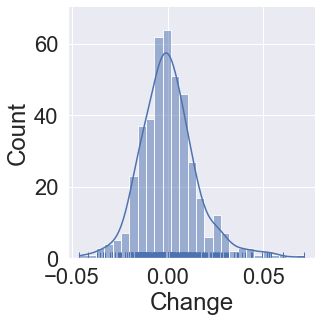

<Figure size 1080x720 with 0 Axes>

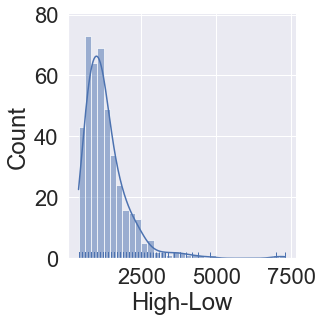

<Figure size 1080x720 with 0 Axes>

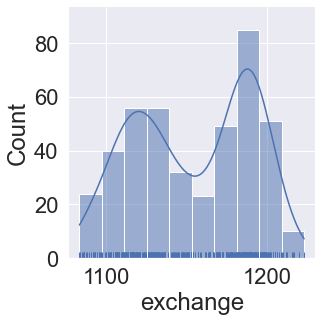

<Figure size 1080x720 with 0 Axes>

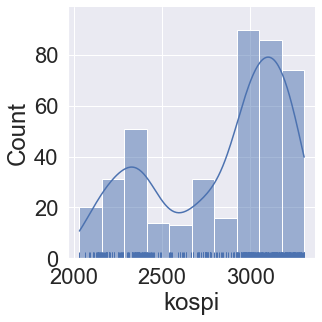

<Figure size 1080x720 with 0 Axes>

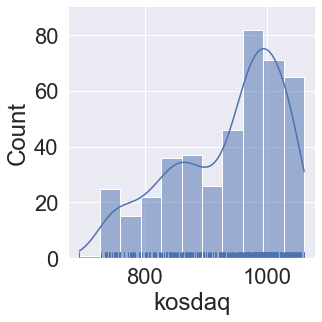

<Figure size 1080x720 with 0 Axes>

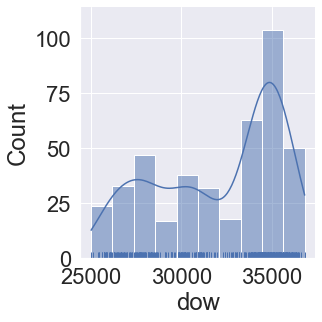

<Figure size 1080x720 with 0 Axes>

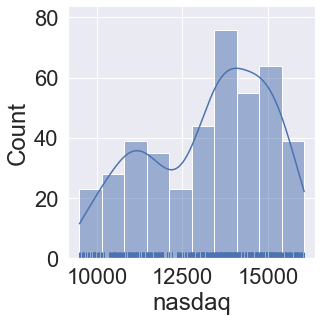

<Figure size 1080x720 with 0 Axes>

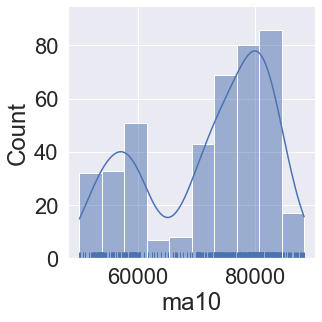

<Figure size 1080x720 with 0 Axes>

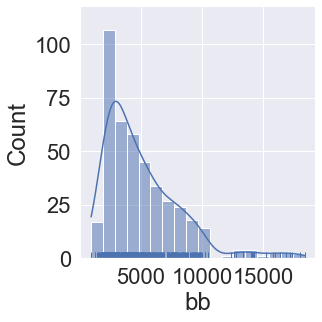

<Figure size 1080x720 with 0 Axes>

In [33]:
#분포도 확인(밀도 포함)
for col in df.columns:
    if col in ['Volume','Change','High-Low','exchange','kospi',
              'kosdaq','dow','nasdaq','ma10','bb']:
        sns.displot(data=df, x=df[col], kde=True, rug=True)
        plt.figure(figsize=(15,10))

In [34]:
#EDA로사용하지 않을 변수들 제거
df=df.drop(['Open','High','Low','sp500'],axis=1)

In [35]:
df

,Close,Volume,Change,High-Low,Close-Open,exchange,kospi,kosdaq,dow,nasdaq,ma10,bb
Date,,,,,,,,,,,,
2020-06-01,1,16949183.0,0.009862,600.0,400.0,1222.92,2065.08,735.72,25383.11,9489.87,49930.0,3152.706069
2020-06-02,1,14247933.0,0.003906,700.0,400.0,1219.62,2087.19,743.58,25475.02,9552.05,50040.0,3650.022831
2020-06-03,1,49257814.0,0.060311,3300.0,2700.0,1215.79,2147.00,737.66,25742.65,9608.38,50490.0,6714.362715
2020-06-04,1,40220334.0,0.001835,2400.0,-1200.0,1216.39,2151.18,742.37,26269.89,9682.91,50955.0,8411.341550
2020-06-05,1,22743629.0,0.016484,1900.0,1100.0,1202.02,2181.87,749.31,26281.82,9615.81,51630.0,9525.264651
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-14,0,13993255.0,-0.016021,1400.0,-700.0,1197.32,2704.48,852.79,34737.47,13791.15,73710.0,4624.379838
2022-02-15,1,9320365.0,0.000000,1100.0,-400.0,1196.76,2676.54,839.92,34565.78,13790.92,73950.0,3167.894499
2022-02-16,1,10767386.0,0.014925,700.0,200.0,1196.53,2729.68,878.15,34988.31,14139.76,74100.0,3188.869531


최종 데이터셋 = df

# 로그변환

In [36]:
#로그변환 먼저해야한다고함 (왜도 심한 변수들 로그변환!)
df['Volume']=np.log(df['Volume'])
df['High-Low']=np.log(df['High-Low'])
df['bb']=np.log(df['bb'])


## 변수 스케일링

minmax 정규화 함수를 정의합니다
- 첫번째 범위 : 0 ~ 1 ->양수만 있는 경우
- 두번째 범위 : -1 ~ 1 -> 음수도 있는 경우

In [37]:
def minmax_norm1(df_input):
    return (df_input - df_input.min()) / ( df_input.max() - df_input.min())

In [38]:
def minmax_norm2(df_input):
    return 2*(df_input - df_input.min()) / ( df_input.max() - df_input.min())-1

Change와 Close-Open의 경우만 음수가 존재하므로 해당 데이터를 제외한 df를 생성합니다

In [39]:
df_tempo = df.drop(['Close-Open', 'Close', 'Change'], axis=1) #change는 빼주기 >> 원래분포가 -1에서 1사이로 보임 굳이 변환할필요 없어보인다!
df_tempo

,Volume,High-Low,exchange,kospi,kosdaq,dow,nasdaq,ma10,bb
Date,,,,,,,,,
2020-06-01,16.645730,6.396930,1222.92,2065.08,735.72,25383.11,9489.87,49930.0,8.056016
2020-06-02,16.472122,6.551080,1219.62,2087.19,743.58,25475.02,9552.05,50040.0,8.202489
2020-06-03,17.712579,8.101678,1215.79,2147.00,737.66,25742.65,9608.38,50490.0,8.812004
2020-06-04,17.509883,7.783224,1216.39,2151.18,742.37,26269.89,9682.91,50955.0,9.037336
2020-06-05,16.939796,7.549609,1202.02,2181.87,749.31,26281.82,9615.81,51630.0,9.161703
...,...,...,...,...,...,...,...,...,...
2022-02-14,16.454086,7.244228,1197.32,2704.48,852.79,34737.47,13791.15,73710.0,8.439098
2022-02-15,16.047712,7.003065,1196.76,2676.54,839.92,34565.78,13790.92,73950.0,8.060822
2022-02-16,16.192032,6.551080,1196.53,2729.68,878.15,34988.31,14139.76,74100.0,8.067422


첫번재 함수로 정규화를 진행합니다

In [40]:
df_tempo=minmax_norm1(df_tempo)
df_tempo

,Volume,High-Low,exchange,kospi,kosdaq,dow,nasdaq,ma10,bb
Date,,,,,,,,,
2020-06-01,0.295738,0.139615,1.000000,0.026883,0.116042,0.031191,0.000000,0.000000,0.406213
2020-06-02,0.222656,0.192694,0.976325,0.044233,0.137468,0.038991,0.009468,0.002851,0.455501
2020-06-03,0.744840,0.726616,0.948849,0.091165,0.121330,0.061702,0.018045,0.014515,0.660606
2020-06-04,0.659513,0.616962,0.953153,0.094445,0.134169,0.106443,0.029393,0.026568,0.736432
2020-06-05,0.419528,0.536521,0.850061,0.118527,0.153087,0.107456,0.019176,0.044064,0.778282
...,...,...,...,...,...,...,...,...,...
2022-02-14,0.215063,0.431368,0.816343,0.528614,0.435164,0.825003,0.654927,0.616382,0.535121
2022-02-15,0.043996,0.348328,0.812325,0.506689,0.400082,0.810434,0.654892,0.622602,0.407830
2022-02-16,0.104749,0.192694,0.810675,0.548388,0.504293,0.846289,0.708008,0.626490,0.410051


음수가 포함된 변수들만으로 이루어진 데이터셋을 만듭니다

In [41]:
df_tempo2=df[['Change','Close-Open']]
df_tempo2

,Change,Close-Open
Date,,
2020-06-01,0.009862,400.0
2020-06-02,0.003906,400.0
2020-06-03,0.060311,2700.0
2020-06-04,0.001835,-1200.0
2020-06-05,0.016484,1100.0
...,...,...
2022-02-14,-0.016021,-700.0
2022-02-15,0.000000,-400.0
2022-02-16,0.014925,200.0


정규화를 진행합니다

In [42]:
df_tempo2=minmax_norm2(df_tempo2)
df_tempo2

,Change,Close-Open
Date,,
2020-06-01,-0.047473,-0.275
2020-06-02,-0.149228,-0.275
2020-06-03,0.814473,0.300
2020-06-04,-0.184618,-0.675
2020-06-05,0.065660,-0.100
...,...,...
2022-02-14,-0.489698,-0.550
2022-02-15,-0.215968,-0.475
2022-02-16,0.039038,-0.325


둘을 합치면 정규화가 완료된 데이터셋이 완성됩니다.(혹시 모를 상황으로 지워질지 몰라서 원본 유지를 위해 다른 데이터 셋을 형성했습니다.)

In [43]:
df2 = pd.concat([df['Close'], df_tempo, df_tempo2],axis=1)
df2

,Close,Volume,High-Low,exchange,kospi,kosdaq,dow,nasdaq,ma10,bb,Change,Close-Open
Date,,,,,,,,,,,,
2020-06-01,1,0.295738,0.139615,1.000000,0.026883,0.116042,0.031191,0.000000,0.000000,0.406213,-0.047473,-0.275
2020-06-02,1,0.222656,0.192694,0.976325,0.044233,0.137468,0.038991,0.009468,0.002851,0.455501,-0.149228,-0.275
2020-06-03,1,0.744840,0.726616,0.948849,0.091165,0.121330,0.061702,0.018045,0.014515,0.660606,0.814473,0.300
2020-06-04,1,0.659513,0.616962,0.953153,0.094445,0.134169,0.106443,0.029393,0.026568,0.736432,-0.184618,-0.675
2020-06-05,1,0.419528,0.536521,0.850061,0.118527,0.153087,0.107456,0.019176,0.044064,0.778282,0.065660,-0.100
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-14,0,0.215063,0.431368,0.816343,0.528614,0.435164,0.825003,0.654927,0.616382,0.535121,-0.489698,-0.550
2022-02-15,1,0.043996,0.348328,0.812325,0.506689,0.400082,0.810434,0.654892,0.622602,0.407830,-0.215968,-0.475
2022-02-16,1,0.104749,0.192694,0.810675,0.548388,0.504293,0.846289,0.708008,0.626490,0.410051,0.039038,-0.325


In [44]:
df2[['Volume','Change','Close-Open','High-Low','exchange','kospi',
              'kosdaq','dow','nasdaq','ma10','bb']] = df2[['Volume','Change','Close-Open','High-Low','exchange','kospi',
              'kosdaq','dow','nasdaq','ma10','bb']].shift(5)
df2=df2.dropna()
df2

,Close,Volume,High-Low,exchange,kospi,kosdaq,dow,nasdaq,ma10,bb,Change,Close-Open
Date,,,,,,,,,,,,
2020-06-08,0,0.295738,0.139615,1.000000,0.026883,0.116042,0.031191,0.000000,0.000000,0.406213,-0.047473,-0.275
2020-06-09,1,0.222656,0.192694,0.976325,0.044233,0.137468,0.038991,0.009468,0.002851,0.455501,-0.149228,-0.275
2020-06-10,0,0.744840,0.726616,0.948849,0.091165,0.121330,0.061702,0.018045,0.014515,0.660606,0.814473,0.300
2020-06-11,0,0.659513,0.616962,0.953153,0.094445,0.134169,0.106443,0.029393,0.026568,0.736432,-0.184618,-0.675
2020-06-12,0,0.419528,0.536521,0.850061,0.118527,0.153087,0.107456,0.019176,0.044064,0.778282,0.065660,-0.100
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-14,0,0.222446,0.378289,0.813114,0.560456,0.562219,0.854897,0.701651,0.622343,0.618495,-0.446851,-0.500
2022-02-15,1,0.141034,0.378289,0.809384,0.561563,0.550961,0.855015,0.689113,0.614567,0.541368,-0.098944,-0.450
2022-02-16,1,0.060764,0.192694,0.792883,0.579124,0.592558,0.886553,0.716336,0.612234,0.498654,0.062977,-0.275


***

# 모델링

In [45]:
# 최종 예측할 5일의 데이터 셋 형성
day_list = ['2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18']

df_recent = df2.loc[day_list]
df_recent

,Close,Volume,High-Low,exchange,kospi,kosdaq,dow,nasdaq,ma10,bb,Change,Close-Open
Date,,,,,,,,,,,,
2022-02-14,0,0.222446,0.378289,0.813114,0.560456,0.562219,0.854897,0.701651,0.622343,0.618495,-0.446851,-0.500
2022-02-15,1,0.141034,0.378289,0.809384,0.561563,0.550961,0.855015,0.689113,0.614567,0.541368,-0.098944,-0.450
2022-02-16,1,0.060764,0.192694,0.792883,0.579124,0.592558,0.886553,0.716336,0.612234,0.498654,0.062977,-0.275
2022-02-17,1,0.315078,0.348328,0.834350,0.581541,0.552079,0.912459,0.761393,0.613012,0.515360,-0.055864,-0.425
2022-02-18,0,0.157519,0.279230,0.831839,0.562536,0.502303,0.867791,0.714994,0.615345,0.537234,-0.329266,-0.400


In [46]:
# 학습, 테스트, 검증할 데이터셋 형성
df_fellow = df2.drop([df2.index[-5],df2.index[-4],df2.index[-3],df2.index[-2],df2.index[-1]])
df_fellow

,Close,Volume,High-Low,exchange,kospi,kosdaq,dow,nasdaq,ma10,bb,Change,Close-Open
Date,,,,,,,,,,,,
2020-06-08,0,0.295738,0.139615,1.000000,0.026883,0.116042,0.031191,0.000000,0.000000,0.406213,-0.047473,-0.275
2020-06-09,1,0.222656,0.192694,0.976325,0.044233,0.137468,0.038991,0.009468,0.002851,0.455501,-0.149228,-0.275
2020-06-10,0,0.744840,0.726616,0.948849,0.091165,0.121330,0.061702,0.018045,0.014515,0.660606,0.814473,0.300
2020-06-11,0,0.659513,0.616962,0.953153,0.094445,0.134169,0.106443,0.029393,0.026568,0.736432,-0.184618,-0.675
2020-06-12,0,0.419528,0.536521,0.850061,0.118527,0.153087,0.107456,0.019176,0.044064,0.778282,0.065660,-0.100
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,0,0.183315,0.405850,0.814262,0.532349,0.515033,0.787687,0.616578,0.677035,0.629871,-0.377586,-0.525
2022-02-08,1,0.410759,0.657519,0.862616,0.458000,0.425460,0.776686,0.617009,0.659927,0.719134,-0.682144,-1.000
2022-02-09,1,0.393253,0.631018,0.904154,0.496332,0.489901,0.776065,0.588179,0.649559,0.714959,0.263286,0.125


In [47]:
X = df_fellow[["Volume","Change","High-Low","exchange","kospi","kosdaq","dow","nasdaq","ma10","bb","Close-Open"]]
X
y=df_fellow[["Close"]]

In [48]:
y

,Close
Date,
2020-06-08,0
2020-06-09,1
2020-06-10,0
2020-06-11,0
2020-06-12,0
...,...
2022-02-07,0
2022-02-08,1
2022-02-09,1


In [49]:
# 훈련, 테스트 셋 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

In [50]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(332, 11)
(84, 11)
(332, 1)
(84, 1)


In [51]:
# 데이터프레임 -> 넘파이 변환
# X: 2차원 -> 3차원 변환
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization, Activation
import random as rn

In [53]:
seed_num=123
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
model = Sequential()  # 시퀀셜 모델 생성
model.add(LSTM(128, activation='tanh', input_shape=X_train[0].shape))   # LSTM 레이어
#model.add(Dense(128, activation='tanh', input_shape=X_train[0].shape))   # FC 레이어
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))   # FC 레이어
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))   # FC 레이어
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))   # FC 레이어

In [54]:
# 컴파일
model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [56]:
# n번(patience)의 에포크 이상 검증 세트에서의 손실이 감소하지 않으면 학습 자동 중단
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [57]:
# 학습
hist = model.fit(X_train, y_train,
                 epochs=105,
                 batch_size=32,
                 validation_split=0.2,
                  callbacks=[early_stopping],
                 shuffle=False)

Epoch 1/105
9/9 [==============================] - 2s 167ms/step - loss: 0.6940 - accuracy: 0.5094 - precision: 0.5399 - recall: 0.6154 - val_loss: 0.6955 - val_accuracy: 0.4478 - val_precision: 0.4478 - val_recall: 1.0000
Epoch 2/105
9/9 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5396 - precision: 0.5475 - recall: 0.8462 - val_loss: 0.6969 - val_accuracy: 0.4478 - val_precision: 0.4478 - val_recall: 1.0000
Epoch 3/105
9/9 [==============================] - 0s 13ms/step - loss: 0.6909 - accuracy: 0.5283 - precision: 0.5402 - recall: 0.8462 - val_loss: 0.6981 - val_accuracy: 0.4478 - val_precision: 0.4478 - val_recall: 1.0000
Epoch 4/105
9/9 [==============================] - 0s 12ms/step - loss: 0.6924 - accuracy: 0.5472 - precision: 0.5481 - recall: 0.9161 - val_loss: 0.7007 - val_accuracy: 0.4478 - val_precision: 0.4478 - val_recall: 1.0000
Epoch 5/105
9/9 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.5170 - precision: 

https://snowdeer.github.io/machine-learning/2018/01/11/keras-use-history-function/  
Keras - history 기능 사용하기

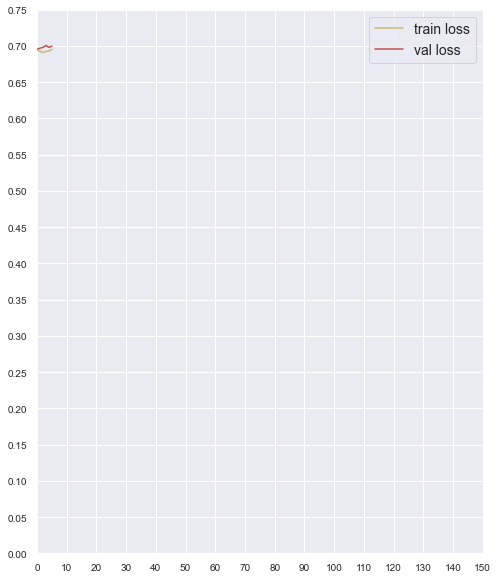

In [58]:
# 학습곡선 시각화
fig, loss_plot = plt.subplots(figsize=(8,10))
loss_plot.plot(hist.history['loss'], 'y', label='train loss')
loss_plot.plot(hist.history['val_loss'], 'r', label='val loss')
plt.yticks(np.arange(0, 0.8, 0.05), fontsize=10)
plt.xticks(np.arange(0, 160, 10), fontsize=10)
loss_plot.legend(fontsize=14)
plt.show()

In [59]:
# 최종 성능 측정
eval = model.evaluate(X_test, y_test)
print(f'F1 Score: {2 * eval[2] * eval[3] / (eval[2] + eval[3])}')

3/3 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5357 - precision: 0.5357 - recall: 1.0000
F1 Score: 0.697674404162855


In [60]:
eval

[0.6905436515808105, 0.5357142686843872, 0.5357142686843872, 1.0]

In [61]:
# 최근 종가로 예측해보기
eval_recent = model.evaluate(df_recent[["Volume","Change","High-Low","exchange","kospi","kosdaq","dow","nasdaq","ma10","bb","Close-Open"]], df_recent[['Close']])
print(2 * eval_recent[2] * eval_recent[3] / (eval_recent[2] + eval_recent[3]))

ValueError: in user code:

    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1174 test_step
        y_pred = self(x, training=False)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 11]


In [64]:
recent_X = df_recent[["Volume","Change","High-Low","exchange","kospi","kosdaq","dow","nasdaq","ma10","bb","Close-Open"]]
recent_y=df_recent[["Close"]]
recent_X=recent_X.to_numpy().reshape(recent_X.shape[0], recent_X.shape[1], 1)
recent_y=recent_y.to_numpy().reshape(recent_y.shape[0], recent_y.shape[1], 1)

In [65]:
eval_recent = model.evaluate(recent_X, recent_y)

print(2 * eval_recent[2] * eval_recent[3] / (eval_recent[2] + eval_recent[3]))

1/1 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.6000 - precision: 0.6000 - recall: 1.0000
0.7500000186264513


***

# 연습장~~~

***

In [ ]:
import torch

# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 데이터 분리

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2, train_size = 0.8, shuffle=False)

# 검증셋쪼개기


:https://stackoverflow.com/questions/48055536/lstm-validation  
https://stats.stackexchange.com/questions/350655/leave-one-out-cross-validation-for-lstm

In [ ]:
import torch.nn as nn
'''
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
  
  def forward(self, x):
    # 한 스텝에서 하나의 sequence를 입력으로 
    # 각 스텝이 끝날 때마다 hidden 값은 연결됨
    output = self.lstm(x)
    return output
'''

In [ ]:
# 모델 클래스

class MultivariateLinearRegression(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear = nn.Linear(5, 1)
    def forward(self, x):
      output = self.linear(x)
      return output

In [ ]:
# 하이퍼파라미터

EPOCHS = 10
lr = 0.01
#input_size = 5
#hidden_size = 2
#num_layers = 1   # Number of recurrent layers

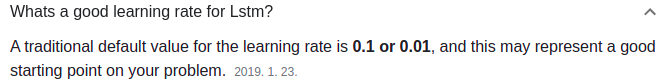

In [ ]:
# 옵티마이저 설정

#optimizer = 

In [ ]:
# 모델 객체 생성

mlr = MultivariateLinearRegression()
mlr = mlr.to(device)

In [ ]:
# 성능 측정 지표 rmse
import math
import torch.nn.functional as F

cost = math.sqrt(F.mse_loss(output, y_train))

# 학습

In [ ]:
# 훈련 함수

from sklearn.model_selection import KFold   # KFold  교차검증

def train():

  kfold = KFold(n_splits=5, shuffle=True)  # 검증은 어따가 코드넣으엉루마

  mlr.zero_grad()
  output = mlr()
  loss = cost(output, y_train)   # loss 계산

  #optimizer.zero_grad()
  loss.backward()   # 역전파

  return loss

In [ ]:
for epoch in tqdm(EPOCHS):
  #outputs = LSTM.forward(train_set.to(device))
  # optimizer
  # loss
  # loss.back()
  # loss값 갱신
  print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, EPOCHS, cost.item())

# 성능 개선
1. layer 정규화 (lstm일경우)
2. epoch
3. 하이퍼파라미터 잘 좀 조정해보기

옵티마이저 - Adam

참고  
https://wonsang0514.tistory.com/9  
https://limitsinx.tistory.com/144

***